# Stage 7 — Outliers + Risk Assumptions



In [2]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
np.random.seed(17)

## Load Data (provided or synthetic fallback)

In [3]:
data_path = Path('../data/raw/fraud_kaggle_creditcard_source-kaggle_dataset-creditcardfraud_20250820-192958.csv')
if data_path.exists():
    print(f"Reading data from {data_path}")
    df = pd.read_csv(data_path)
else:
    # Synthetic fallback: linear trend with noise and a few extremes
    x = np.linspace(0, 10, 200)
    y = 2.2 * x + 1 + np.random.normal(0, 1.2, size=x.size)
    y[10] += 15; y[120] -= 13; y[160] += 18
    df = pd.DataFrame({'x': x, 'y': y})
df.head(100)

Reading data from ../data/raw/fraud_kaggle_creditcard_source-kaggle_dataset-creditcardfraud_20250820-192958.csv


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,64.0,-0.658305,0.406791,2.037461,-0.291298,0.147910,-0.350857,0.945373,-0.172560,0.025133,...,-0.156096,-0.238805,0.089877,0.421195,-0.352487,0.074783,-0.094192,-0.092493,54.99,0
96,64.0,0.959602,0.370711,0.888613,2.343244,0.352491,1.365515,-0.277771,0.516053,-0.700929,...,-0.155547,-0.403239,0.356504,-0.696881,-0.198718,-0.220268,0.068546,0.020797,7.55,0
97,67.0,-0.653445,0.160225,1.592256,1.296832,0.997175,-0.343000,0.469937,-0.132470,-0.197794,...,0.038363,0.336449,-0.014883,0.102959,-0.265322,-0.348637,0.011238,-0.049478,19.85,0
98,67.0,-1.494668,0.837241,2.628211,3.145414,-0.609098,0.258495,-0.012189,0.102136,-0.286164,...,-0.140047,0.355044,0.332720,0.718193,-0.219366,0.118927,-0.317486,-0.340783,28.28,0


## TODO: Implement Outlier Functions (required)

In [4]:
def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """Return boolean mask for IQR-based outliers.
    Assumptions: distribution reasonably summarized by quartiles; k controls strictness.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """Return boolean mask for Z-score outliers where |z| > threshold.
    Assumptions: roughly normal distribution; sensitive to heavy tails.
    """
    mu = series.mean()
    sigma = series.std(ddof=0)
    z = (series - mu) / (sigma if sigma != 0 else 1.0)
    return z.abs() > threshold

*(Stretch)* Implement winsorizing (optional).

In [5]:
def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return series.clip(lower=lo, upper=hi)

## Apply Detection and Create Flags (choose a numeric column)

In [10]:
target_col = 'Amount'
df['outlier_iqr'] = detect_outliers_iqr(df[target_col])
df['outlier_z'] = detect_outliers_zscore(df[target_col], threshold=3.0)
df[['outlier_iqr', 'outlier_z']].mean()  # fraction flagged

outlier_iqr    0.112020
outlier_z      0.014311
dtype: float64

### Visual Checks (boxplot / histogram)

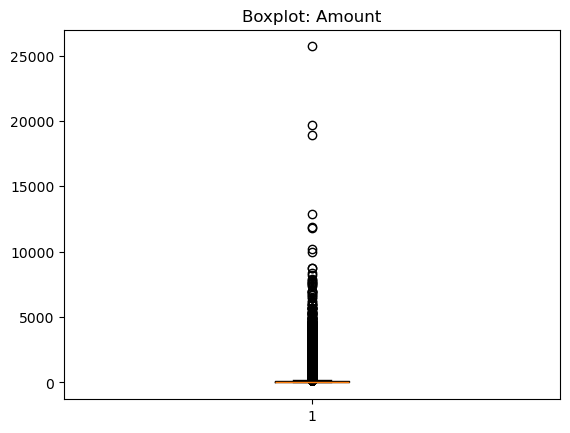

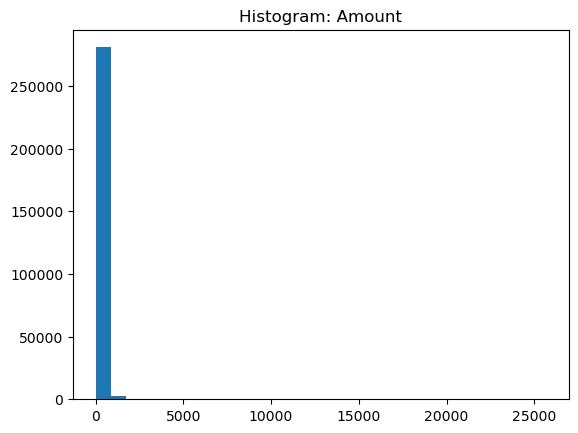

In [11]:
plt.figure()
plt.boxplot(df[target_col])
plt.title(f'Boxplot: {target_col}')
plt.show()

plt.figure()
plt.hist(df[target_col], bins=30)
plt.title(f'Histogram: {target_col}')
plt.show()

## Sensitivity Analysis
Pick one: summary stats or simple linear regression comparing **all vs. filtered** (and optional winsorized).

In [12]:
# Option A: Summary stats
summ_all = df[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_filtered = df.loc[~df['outlier_iqr'], target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_w = None
if 'winsorize_series' in globals():
    w = winsorize_series(df[target_col])
    summ_w = w.describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

comp = pd.concat(
    {
        'all': summ_all,
        'filtered_iqr': summ_filtered,
        **({'winsorized': summ_w} if summ_w is not None else {})
    }, axis=1
)
comp

,all,filtered_iqr,winsorized
mean,88.349619,34.974887,65.169812
median,22.000000,16.000000,22.000000
std,250.120109,42.172250,96.373372


In [14]:
# Option B: Simple regression (if x present)
if 'x' in df.columns:
    X_all = df[['time']].to_numpy(); y_all = df[target_col].to_numpy()
    X_filtered = df.loc[~df['outlier_iqr'], ['x']].to_numpy(); y_filtered = df.loc[~df['outlier_iqr'], target_col].to_numpy()

    model_all = LinearRegression().fit(X_all, y_all)
    model_flt = LinearRegression().fit(X_filtered, y_filtered)

    mae_all = mean_absolute_error(y_all, model_all.predict(X_all))
    mae_flt = mean_absolute_error(y_filtered, model_flt.predict(X_filtered))

    results = pd.DataFrame({
        'slope': [model_all.coef_[0], model_flt.coef_[0]],
        'intercept': [model_all.intercept_, model_flt.intercept_],
        'r2': [model_all.score(X_all, y_all), model_flt.score(X_filtered, y_filtered)],
        'mae': [mae_all, mae_flt]
    }, index=['all', 'filtered_iqr'])
    results
else:
    results = None
    print("No 'x' column; skip regression or engineer features.")

No 'x' column; skip regression or engineer features.


### Reflection (≤ 1 page)
- Methods and thresholds used (and why)
- Assumptions behind choices
- Observed impact on results
- Risks if assumptions are wrong (e.g., discarding true events)

Methods used, with assumptions at the end:
IQR method. The IQR method utilizes the interquartile range to see low variability and high consistency in data. the lower hte iqr, the better it generally is. In this case 1.5 times the iqr was used for a longer range. This method is nice because it doesn't assume normality in elements (better for skewed distributions) and is less senstive than the z-score to outliers. After doing some research on financial returns, this is the better method because returns don't always follow normal distirbutions, for which the z-score method is better. 

Winsorizing is also used, wherein the extreme values below the 5th and above the 95th percentile are replaced by less extreme values at the end of each side, so the data isn't removed. This is good because the data volume is kept while reducing the impact of outliers. The assumption is that by using less extreme values, there will be better ersults as reducing the strength of outliers is better than removing them completely.

Impact on results:
Accoridng to the results for Method 1, we can see IQR is better than Winsorization for all three metrics. The iqr result is around half of the winsorization value for mean and std, and smaller for median. Both values are far less than the unfiltered/winsorized values except for th emedian in winsorization, which suggests that there was an outlier that was not removed by winsorization but was for iqr, or that the iqr removed too much. 

Risks: 
For a credit card fraud detection case, it is important to use most values as fraud values can range from large transactions to small, and the timing can also be a big factor. For this use case, since the data is really high quality, it might be better to not filter as there are no columns to fill or replace and the dataset is comprehensive. The best case would be we use a very small winsorization for 2% of each area, but even still the dataset quality is good enough for 100% use.
Furthermore, if using Z-score analysis, the distribution should be centered around a normal distribution, since z-scores do not work well for skewed distributions; this can create problematic filtering if the distribution type is not taken account for. 

